# **Notebook: Double Descent**

Nombre:

Numero de estudiante:

---

Esta notebook investiga el fenómeno **double descent** que ocurre en las Redes Neuronales.

En el aprendizaje automático, a menudo esperamos que a medida que la capacidad de un modelo (por ejemplo, el número de parámetros) aumenta, el error de entrenamiento disminuya y el error de prueba eventualmente aumente después de cierto punto (el clásico "overfitting"). Sin embargo, el fenómeno de Double Descent desafía esta intuición al mostrar que, en ciertos escenarios, a medida que la capacidad del modelo continúa aumentando más allá del punto de overfitting, el error de prueba puede volver a disminuir.

En esta notebook:

- Utilizamos el dataset MNIST-1D que se puede encontrar en https://github.com/greydanus/mnist1d.
- Entrenamos redes con diferentes capacidades (variando el número de unidades ocultas)
- Analizamos cómo el ruido en las etiquetas del conjunto de entrenamiento influye en la forma de la curva Double Descent.

## Dataset

In [17]:
!pip install torchinfo

In [18]:
# Instalar el dataset MNIST 1D
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-tmrrr2f2
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-tmrrr2f2
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
from torchinfo import summary
import torch.optim as optim

from sklearn.model_selection import train_test_split

import random
random.seed(0)

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_sweep_metrics_comparison,
    download_run,
    plot_class_distribution
)


In [20]:
# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

Usando cuda


In [21]:
LR = 1e-3 #0.001
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
BATCH_SIZE = 16
EPOCHS = 10_000
# [2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250, 300]
# [8, 16, 32, 40, 45, 50, 64, 128, 256, 512]
HIDDEN_SIZES = [15, 32, 40, 42, 45, 48, 50, 52, 55, 60, 70, 120, 200, 300]
LONG_HIDDEN_SIZES = [2, 40, 80, 120, 200, 300, 400, 500]

In [22]:
def get_noisy_mnist1d_dataset(noise_rate=0.0):
    """
    Generates the MNIST-1D dataset with a specified amount of noise in the training labels.

    Args:
        noise_rate (float): The proportion of training labels to flip randomly.

    Returns:
        dict: A dictionary containing the noisy dataset.
    """
    args = mnist1d.data.get_dataset_args()
    args.num_samples = 8000
    args.train_split = 0.5
    args.corr_noise_scale = 0.25
    args.iid_noise_scale = 2e-2
    data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl',
                                    download=False, regenerate=True)

    # Add noise to training labels
    for c_y in range(len(data['y'])):
        random_number = random.random()
        if random_number < noise_rate:
            random_int = int(random.random() * 10)
            data['y'][c_y] = random_int

    return data

In [23]:
data = get_noisy_mnist1d_dataset(noise_rate=0.0)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


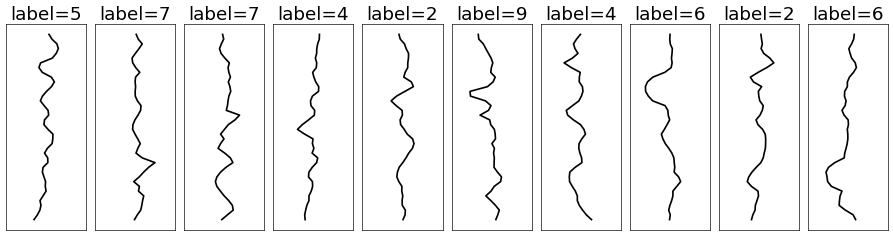

In [24]:
def plot_signals(xs, t, labels=None, ratio=2.6, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig


# Sample 10 random examples from test
num_test_examples = len(data['y_test'])
sample_indices_test = random.sample(range(num_test_examples), 10)

xs = data['x_test'][sample_indices_test]
labels = data['y_test'][sample_indices_test]
t = data['t']
_ = plot_signals(xs, t, labels=labels, ratio=2.7, zoom=6)

Ahora definiremos la función `get_model`, encargada de construir nuestra red neuronal.

**Tarea:**
Completa la función `get_model` con las siguientes especificaciones:

1. Define las dimensiones:
    * Entrada (D_i): debe coincidir con la dimensionalidad de cada muestra del dataset MNIST-1D.
    * Oculta (n_hidden): se recibe como argumento de la función.
    * Salida (D_o): igual al número de clases.

2. Crea una arquitectura secuencial con las siguientes capas:
    - Capa lineal de entrada.
    - Activación ReLU.
    - Capa lineal oculta.
    - Activación ReLU.
    - Capa lineal de salida.

3. Devuelve el modelo resultante.

In [25]:
print(data['x'].shape) #(N, D)
print(f"Número de ejemplos de entrenamiento: {data['x'].shape[0]}")
print(f"Dimensionalidad de cada ejemplo: {data['x'].shape[-1]}")
INPUT_DIM = data['x'].shape[-1]
OUTPUT_DIM = len(np.unique(data['y']))
print(f"Número de clases: {OUTPUT_DIM}")

(4000, 40)
Número de ejemplos de entrenamiento: 4000
Dimensionalidad de cada ejemplo: 40
Número de clases: 10


In [26]:
def get_model(n_hidden):
  D_i = INPUT_DIM    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = OUTPUT_DIM    # Output dimensions

  # Completar
  model = nn.Sequential(
    nn.Linear(D_i, D_k), # capa lineal de entrada
    nn.ReLU(), # activación ReLU
    nn.Linear(D_k, D_k), # capa lineal oculta
    nn.ReLU(), # activación ReLU
    nn.Linear(D_k, D_o) # capa lineal de salida
  )

  # Return the model
  return model;

In [27]:
model = get_model(n_hidden=64)  # por ejemplo
summary(model, input_size=(BATCH_SIZE,INPUT_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 10]                  --
├─Linear: 1-1                            [16, 64]                  2,624
├─ReLU: 1-2                              [16, 64]                  --
├─Linear: 1-3                            [16, 64]                  4,160
├─ReLU: 1-4                              [16, 64]                  --
├─Linear: 1-5                            [16, 10]                  650
Total params: 7,434
Trainable params: 7,434
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.05

## Entrenamiento y visualización de la curva *Double Descent*

En esta sección vamos a explorar cómo varían el **error de entrenamiento** y el **error de prueba** al aumentar la capacidad de una red neuronal.

**Tu tarea:**

1. Entrena redes neuronales con distintos números de unidades ocultas (`n_hidden`) durante **1000 épocas**, usando los siguientes tamaños de capa oculta:  
   `[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`.  
2. Registra los errores finales de entrenamiento y prueba para cada modelo.  
3. Grafica los errores en función del número de unidades ocultas para visualizar la **curva de Double Descent**.  
4. Añade una línea vertical que marque el **interpolation threshold**, que se puede representar como el punto en que el número de parámetros del modelo se aproxima al número de ejemplos de entrenamiento. El pico del error de prueba suele aparecer cerca de esta región.

> 💡 **Nota:** la ejecución del código puede tomar un tiempo considerable, ¡así que quizás sea un buen momento para tomar un descanso!


In [28]:
def get_dataloaders(data):
    # Dividimos train/val
    X_train, X_val, y_train, y_val = train_test_split(
        data['x'], data['y'], test_size=0.2, random_state=42
    )

    # Convertimos a tensores
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Creamos datasets y dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader


In [29]:
def train_model(n_hidden, train_loader, val_loader):
    base_model = get_model(n_hidden).to(DEVICE)

    optimizer = optim.SGD(base_model.parameters(), lr=LR)


    epoch_train_errors, epoch_val_errors = train(
        base_model,
        optimizer,
        CRITERION,
        train_loader,
        val_loader,
        DEVICE,
        do_early_stopping=True,
        patience=3000,
        epochs=EPOCHS,
        log_every=500,
    )

    plot_training(epoch_train_errors, epoch_val_errors, n_hidden)

    return epoch_train_errors[-1], epoch_val_errors[-1]

In [30]:
train_loader, val_loader = get_dataloaders(data)


Entrenando modelo con 15 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.25920 | Val Loss: 1.29490
Epoch: 1000/10000 | Train Loss: 1.13036 | Val Loss: 1.24166
Epoch: 1500/10000 | Train Loss: 1.06580 | Val Loss: 1.24157
Epoch: 2000/10000 | Train Loss: 1.02686 | Val Loss: 1.27539
Epoch: 2500/10000 | Train Loss: 0.99627 | Val Loss: 1.31259
Epoch: 3000/10000 | Train Loss: 0.97158 | Val Loss: 1.36794
Epoch: 3500/10000 | Train Loss: 0.95260 | Val Loss: 1.42479
Epoch: 4000/10000 | Train Loss: 0.93765 | Val Loss: 1.46329
Epoch: 4500/10000 | Train Loss: 0.92588 | Val Loss: 1.49793
Epoch: 5000/10000 | Train Loss: 0.91456 | Val Loss: 1.53329
Epoch: 5500/10000 | Train Loss: 0.90613 | Val Loss: 1.57417
Epoch: 6000/10000 | Train Loss: 0.89754 | Val Loss: 1.59960
Epoch: 6500/10000 | Train Loss: 0.89023 | Val Loss: 1.63655
Epoch: 7000/10000 | Train Loss: 0.88265 | Val Loss: 1.67727
Epoch: 7500/10000 | Train Loss: 0.87564 | Val Loss: 1.72402
Epoch: 8000/10000 | Train Loss: 0.86999 | Val Loss: 1.7752

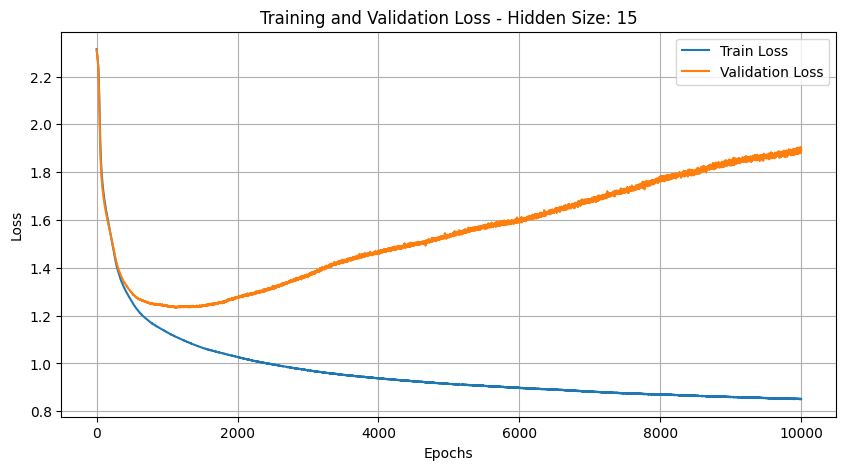


Entrenando modelo con 32 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.21174 | Val Loss: 1.28368
Epoch: 1000/10000 | Train Loss: 0.95072 | Val Loss: 1.18063
Epoch: 1500/10000 | Train Loss: 0.73171 | Val Loss: 1.12892
Epoch: 2000/10000 | Train Loss: 0.63334 | Val Loss: 1.22311
Epoch: 2500/10000 | Train Loss: 0.55320 | Val Loss: 1.37750
Epoch: 3000/10000 | Train Loss: 0.47621 | Val Loss: 1.56498
Epoch: 3500/10000 | Train Loss: 0.40751 | Val Loss: 1.79644
Epoch: 4000/10000 | Train Loss: 0.34933 | Val Loss: 2.07329
Epoch: 4500/10000 | Train Loss: 0.29793 | Val Loss: 2.36367
Epoch: 5000/10000 | Train Loss: 0.24933 | Val Loss: 2.73365
Epoch: 5500/10000 | Train Loss: 0.20552 | Val Loss: 3.15506
Epoch: 6000/10000 | Train Loss: 0.16811 | Val Loss: 3.61137
Epoch: 6500/10000 | Train Loss: 0.13534 | Val Loss: 4.08471
Epoch: 7000/10000 | Train Loss: 0.10983 | Val Loss: 4.56213
Epoch: 7500/10000 | Train Loss: 0.08955 | Val Loss: 5.04334
Epoch: 8000/10000 | Train Loss: 0.07244 | Val Loss: 5.5321

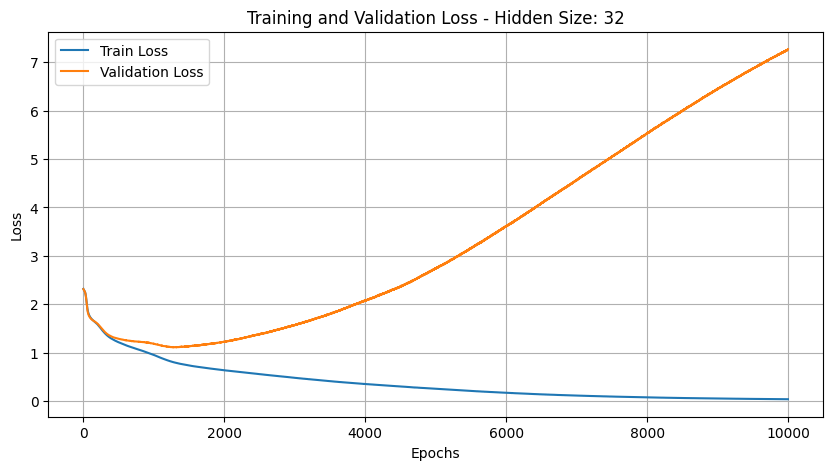


Entrenando modelo con 40 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.17165 | Val Loss: 1.26623
Epoch: 1000/10000 | Train Loss: 0.92340 | Val Loss: 1.26408
Epoch: 1500/10000 | Train Loss: 0.66679 | Val Loss: 1.25594
Epoch: 2000/10000 | Train Loss: 0.50481 | Val Loss: 1.43690
Epoch: 2500/10000 | Train Loss: 0.37574 | Val Loss: 1.71501
Epoch: 3000/10000 | Train Loss: 0.27016 | Val Loss: 2.10216
Epoch: 3500/10000 | Train Loss: 0.18796 | Val Loss: 2.54074
Epoch: 4000/10000 | Train Loss: 0.12528 | Val Loss: 3.03319
Epoch: 4500/10000 | Train Loss: 0.07989 | Val Loss: 3.50414
Epoch: 5000/10000 | Train Loss: 0.05233 | Val Loss: 3.94674
Epoch: 5500/10000 | Train Loss: 0.03616 | Val Loss: 4.34198
Epoch: 6000/10000 | Train Loss: 0.02638 | Val Loss: 4.66756
Epoch: 6500/10000 | Train Loss: 0.02011 | Val Loss: 4.95420
Epoch: 7000/10000 | Train Loss: 0.01598 | Val Loss: 5.19744
Epoch: 7500/10000 | Train Loss: 0.01300 | Val Loss: 5.40986
Epoch: 8000/10000 | Train Loss: 0.01084 | Val Loss: 5.5983

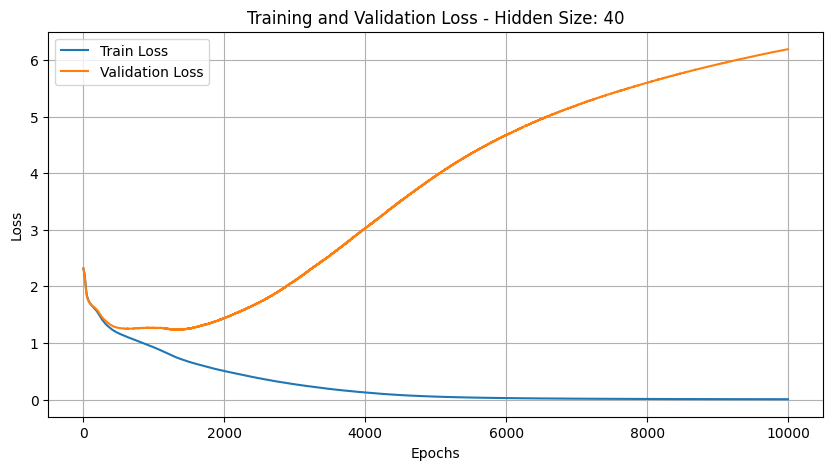


Entrenando modelo con 42 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.15869 | Val Loss: 1.26100
Epoch: 1000/10000 | Train Loss: 0.80702 | Val Loss: 1.11503
Epoch: 1500/10000 | Train Loss: 0.60432 | Val Loss: 1.18185
Epoch: 2000/10000 | Train Loss: 0.45440 | Val Loss: 1.36973
Epoch: 2500/10000 | Train Loss: 0.33129 | Val Loss: 1.62247
Epoch: 3000/10000 | Train Loss: 0.23047 | Val Loss: 1.97031
Epoch: 3500/10000 | Train Loss: 0.15354 | Val Loss: 2.38721
Epoch: 4000/10000 | Train Loss: 0.09914 | Val Loss: 2.83741
Epoch: 4500/10000 | Train Loss: 0.06295 | Val Loss: 3.28574
Epoch: 5000/10000 | Train Loss: 0.04175 | Val Loss: 3.68941
Epoch: 5500/10000 | Train Loss: 0.02914 | Val Loss: 4.01938
Epoch: 6000/10000 | Train Loss: 0.02135 | Val Loss: 4.30376
Epoch: 6500/10000 | Train Loss: 0.01639 | Val Loss: 4.55266
Epoch: 7000/10000 | Train Loss: 0.01304 | Val Loss: 4.76331
Epoch: 7500/10000 | Train Loss: 0.01070 | Val Loss: 4.95001
Epoch: 8000/10000 | Train Loss: 0.00897 | Val Loss: 5.1130

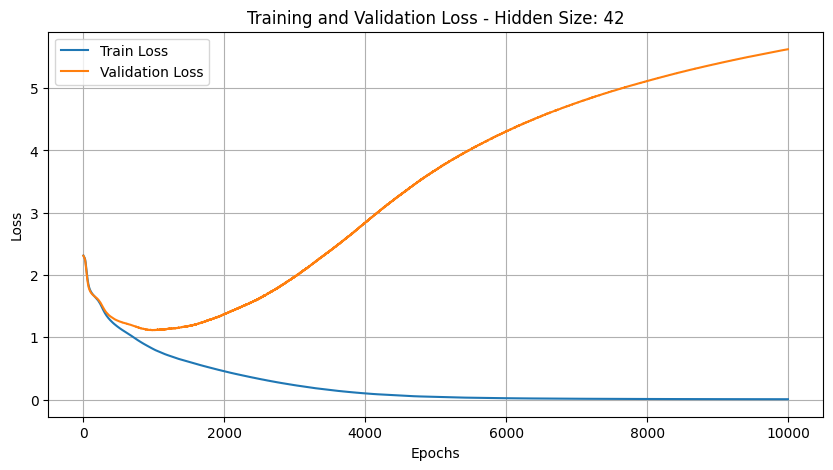


Entrenando modelo con 45 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.14633 | Val Loss: 1.24495
Epoch: 1000/10000 | Train Loss: 0.78999 | Val Loss: 1.05968
Epoch: 1500/10000 | Train Loss: 0.58544 | Val Loss: 1.15232
Epoch: 2000/10000 | Train Loss: 0.43774 | Val Loss: 1.35453
Epoch: 2500/10000 | Train Loss: 0.30990 | Val Loss: 1.62792
Epoch: 3000/10000 | Train Loss: 0.20801 | Val Loss: 1.99588
Epoch: 3500/10000 | Train Loss: 0.13258 | Val Loss: 2.39719
Epoch: 4000/10000 | Train Loss: 0.08290 | Val Loss: 2.85298
Epoch: 4500/10000 | Train Loss: 0.05321 | Val Loss: 3.27892
Epoch: 5000/10000 | Train Loss: 0.03562 | Val Loss: 3.63409
Epoch: 5500/10000 | Train Loss: 0.02551 | Val Loss: 3.94323
Epoch: 6000/10000 | Train Loss: 0.01924 | Val Loss: 4.19959
Epoch: 6500/10000 | Train Loss: 0.01509 | Val Loss: 4.41983
Epoch: 7000/10000 | Train Loss: 0.01221 | Val Loss: 4.60972
Epoch: 7500/10000 | Train Loss: 0.01016 | Val Loss: 4.77420
Epoch: 8000/10000 | Train Loss: 0.00861 | Val Loss: 4.9221

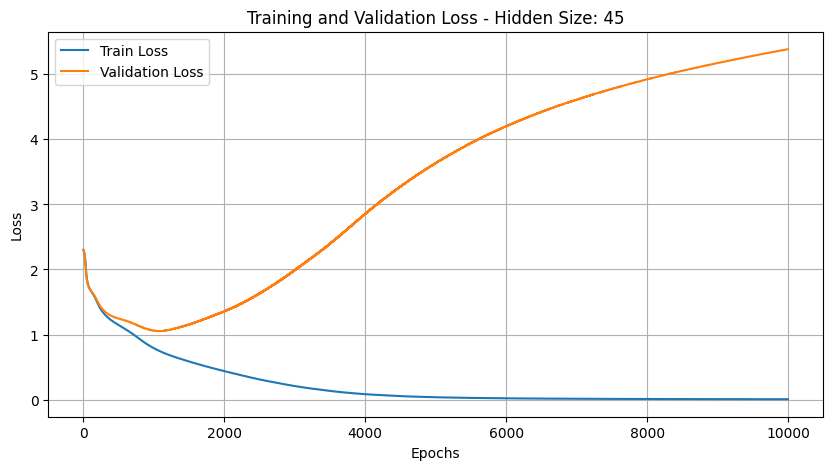


Entrenando modelo con 48 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.13460 | Val Loss: 1.23928
Epoch: 1000/10000 | Train Loss: 0.82356 | Val Loss: 1.18632
Epoch: 1500/10000 | Train Loss: 0.60243 | Val Loss: 1.26996
Epoch: 2000/10000 | Train Loss: 0.42601 | Val Loss: 1.46978
Epoch: 2500/10000 | Train Loss: 0.27514 | Val Loss: 1.79703
Epoch: 3000/10000 | Train Loss: 0.16513 | Val Loss: 2.23815
Epoch: 3500/10000 | Train Loss: 0.09457 | Val Loss: 2.71395
Epoch: 4000/10000 | Train Loss: 0.05480 | Val Loss: 3.18100
Epoch: 4500/10000 | Train Loss: 0.03461 | Val Loss: 3.57626
Epoch: 5000/10000 | Train Loss: 0.02376 | Val Loss: 3.90376
Epoch: 5500/10000 | Train Loss: 0.01739 | Val Loss: 4.16942
Epoch: 6000/10000 | Train Loss: 0.01339 | Val Loss: 4.39413
Epoch: 6500/10000 | Train Loss: 0.01073 | Val Loss: 4.58524
Epoch: 7000/10000 | Train Loss: 0.00884 | Val Loss: 4.74967
Epoch: 7500/10000 | Train Loss: 0.00746 | Val Loss: 4.89393
Epoch: 8000/10000 | Train Loss: 0.00642 | Val Loss: 5.0231

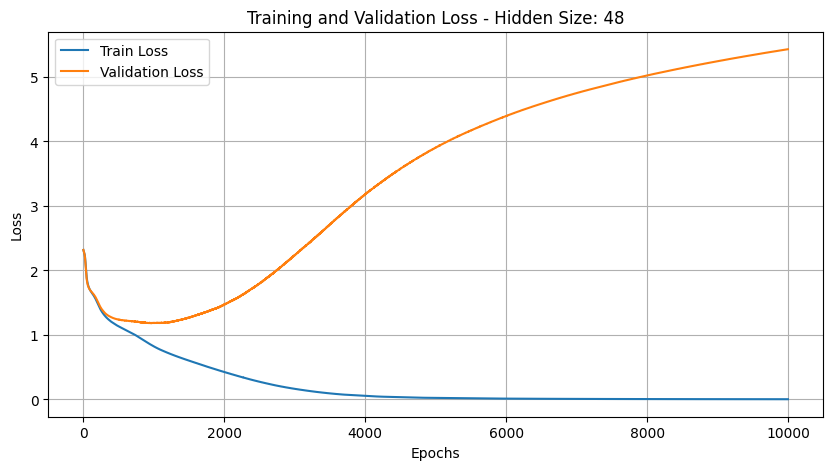


Entrenando modelo con 50 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.09410 | Val Loss: 1.20766
Epoch: 1000/10000 | Train Loss: 0.70329 | Val Loss: 1.12664
Epoch: 1500/10000 | Train Loss: 0.51877 | Val Loss: 1.29872
Epoch: 2000/10000 | Train Loss: 0.36210 | Val Loss: 1.57680
Epoch: 2500/10000 | Train Loss: 0.21866 | Val Loss: 1.99225
Epoch: 3000/10000 | Train Loss: 0.12193 | Val Loss: 2.50286
Epoch: 3500/10000 | Train Loss: 0.06790 | Val Loss: 3.01865
Epoch: 4000/10000 | Train Loss: 0.04076 | Val Loss: 3.46838
Epoch: 4500/10000 | Train Loss: 0.02676 | Val Loss: 3.82977
Epoch: 5000/10000 | Train Loss: 0.01891 | Val Loss: 4.12777
Epoch: 5500/10000 | Train Loss: 0.01418 | Val Loss: 4.37626
Epoch: 6000/10000 | Train Loss: 0.01110 | Val Loss: 4.58159
Epoch: 6500/10000 | Train Loss: 0.00900 | Val Loss: 4.75843
Epoch: 7000/10000 | Train Loss: 0.00750 | Val Loss: 4.91171
Epoch: 7500/10000 | Train Loss: 0.00638 | Val Loss: 5.04658
Epoch: 8000/10000 | Train Loss: 0.00551 | Val Loss: 5.1672

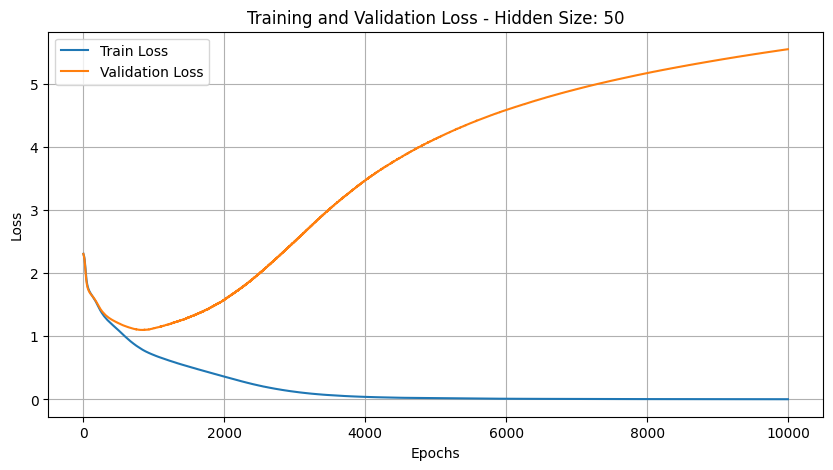


Entrenando modelo con 52 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.05140 | Val Loss: 1.18955
Epoch: 1000/10000 | Train Loss: 0.69710 | Val Loss: 1.10196
Epoch: 1500/10000 | Train Loss: 0.51033 | Val Loss: 1.24987
Epoch: 2000/10000 | Train Loss: 0.35069 | Val Loss: 1.53486
Epoch: 2500/10000 | Train Loss: 0.22012 | Val Loss: 1.93503
Epoch: 3000/10000 | Train Loss: 0.12286 | Val Loss: 2.41347
Epoch: 3500/10000 | Train Loss: 0.06663 | Val Loss: 2.88612
Epoch: 4000/10000 | Train Loss: 0.03907 | Val Loss: 3.28049
Epoch: 4500/10000 | Train Loss: 0.02526 | Val Loss: 3.60794
Epoch: 5000/10000 | Train Loss: 0.01782 | Val Loss: 3.87090
Epoch: 5500/10000 | Train Loss: 0.01337 | Val Loss: 4.08645
Epoch: 6000/10000 | Train Loss: 0.01051 | Val Loss: 4.27292
Epoch: 6500/10000 | Train Loss: 0.00854 | Val Loss: 4.43299
Epoch: 7000/10000 | Train Loss: 0.00713 | Val Loss: 4.57454
Epoch: 7500/10000 | Train Loss: 0.00608 | Val Loss: 4.69877
Epoch: 8000/10000 | Train Loss: 0.00526 | Val Loss: 4.8107

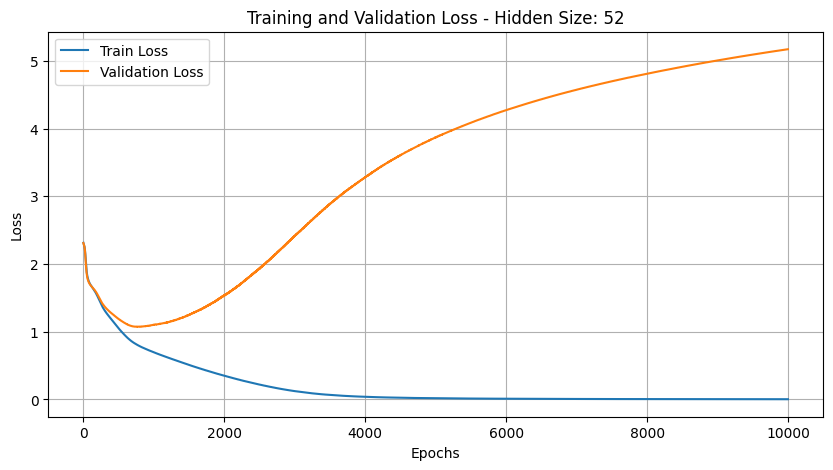


Entrenando modelo con 55 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.12262 | Val Loss: 1.24998
Epoch: 1000/10000 | Train Loss: 0.73740 | Val Loss: 1.13333
Epoch: 1500/10000 | Train Loss: 0.49630 | Val Loss: 1.26488
Epoch: 2000/10000 | Train Loss: 0.31666 | Val Loss: 1.53219
Epoch: 2500/10000 | Train Loss: 0.18197 | Val Loss: 1.88906
Epoch: 3000/10000 | Train Loss: 0.09665 | Val Loss: 2.33010
Epoch: 3500/10000 | Train Loss: 0.05225 | Val Loss: 2.71904
Epoch: 4000/10000 | Train Loss: 0.03138 | Val Loss: 3.04508
Epoch: 4500/10000 | Train Loss: 0.02102 | Val Loss: 3.30535
Epoch: 5000/10000 | Train Loss: 0.01520 | Val Loss: 3.51622
Epoch: 5500/10000 | Train Loss: 0.01162 | Val Loss: 3.69169
Epoch: 6000/10000 | Train Loss: 0.00926 | Val Loss: 3.83939
Epoch: 6500/10000 | Train Loss: 0.00761 | Val Loss: 3.96769
Epoch: 7000/10000 | Train Loss: 0.00641 | Val Loss: 4.08094
Epoch: 7500/10000 | Train Loss: 0.00550 | Val Loss: 4.18109
Epoch: 8000/10000 | Train Loss: 0.00480 | Val Loss: 4.2719

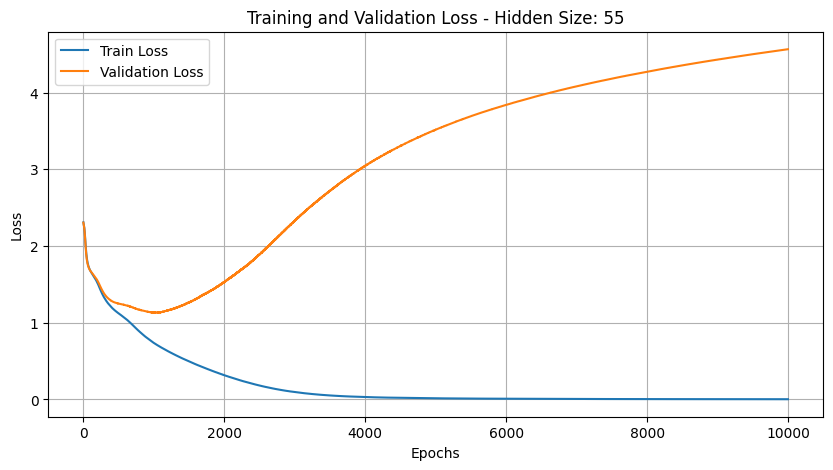


Entrenando modelo con 60 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.06033 | Val Loss: 1.16154
Epoch: 1000/10000 | Train Loss: 0.68030 | Val Loss: 1.05055
Epoch: 1500/10000 | Train Loss: 0.46502 | Val Loss: 1.19463
Epoch: 2000/10000 | Train Loss: 0.27545 | Val Loss: 1.46894
Epoch: 2500/10000 | Train Loss: 0.14094 | Val Loss: 1.86376
Epoch: 3000/10000 | Train Loss: 0.06907 | Val Loss: 2.27947
Epoch: 3500/10000 | Train Loss: 0.03790 | Val Loss: 2.62983
Epoch: 4000/10000 | Train Loss: 0.02360 | Val Loss: 2.90987
Epoch: 4500/10000 | Train Loss: 0.01626 | Val Loss: 3.13264
Epoch: 5000/10000 | Train Loss: 0.01205 | Val Loss: 3.31316
Epoch: 5500/10000 | Train Loss: 0.00938 | Val Loss: 3.46275
Epoch: 6000/10000 | Train Loss: 0.00758 | Val Loss: 3.59101
Epoch: 6500/10000 | Train Loss: 0.00630 | Val Loss: 3.70282
Epoch: 7000/10000 | Train Loss: 0.00534 | Val Loss: 3.80087
Epoch: 7500/10000 | Train Loss: 0.00462 | Val Loss: 3.88825
Epoch: 8000/10000 | Train Loss: 0.00404 | Val Loss: 3.9669

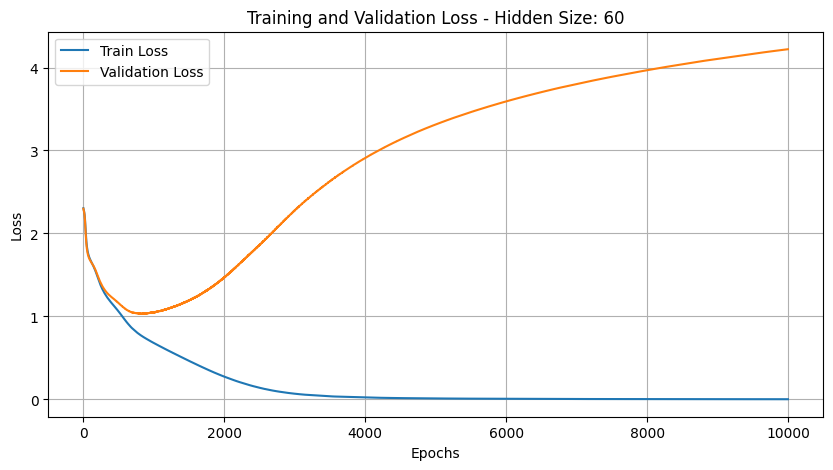


Entrenando modelo con 70 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.06299 | Val Loss: 1.19845
Epoch: 1000/10000 | Train Loss: 0.63034 | Val Loss: 1.05867
Epoch: 1500/10000 | Train Loss: 0.38439 | Val Loss: 1.19632
Epoch: 2000/10000 | Train Loss: 0.19550 | Val Loss: 1.51604
Epoch: 2500/10000 | Train Loss: 0.08795 | Val Loss: 1.93449
Epoch: 3000/10000 | Train Loss: 0.04340 | Val Loss: 2.30884
Epoch: 3500/10000 | Train Loss: 0.02515 | Val Loss: 2.60614
Epoch: 4000/10000 | Train Loss: 0.01660 | Val Loss: 2.83350
Epoch: 4500/10000 | Train Loss: 0.01195 | Val Loss: 3.01643
Epoch: 5000/10000 | Train Loss: 0.00913 | Val Loss: 3.16563
Epoch: 5500/10000 | Train Loss: 0.00728 | Val Loss: 3.29022
Epoch: 6000/10000 | Train Loss: 0.00599 | Val Loss: 3.39839
Epoch: 6500/10000 | Train Loss: 0.00505 | Val Loss: 3.49451
Epoch: 7000/10000 | Train Loss: 0.00434 | Val Loss: 3.57926
Epoch: 7500/10000 | Train Loss: 0.00379 | Val Loss: 3.65506
Epoch: 8000/10000 | Train Loss: 0.00335 | Val Loss: 3.7232

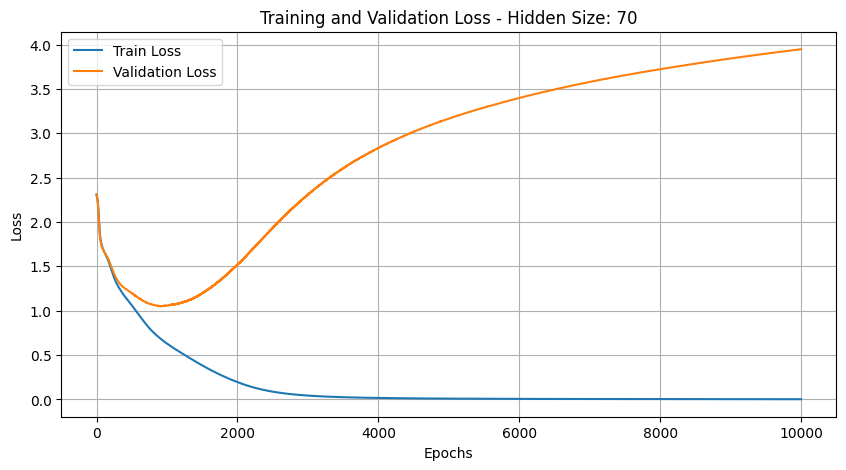


Entrenando modelo con 120 unidades ocultas
Epoch: 500/10000 | Train Loss: 0.90753 | Val Loss: 1.10707
Epoch: 1000/10000 | Train Loss: 0.47450 | Val Loss: 1.11632
Epoch: 1500/10000 | Train Loss: 0.19530 | Val Loss: 1.43834
Epoch: 2000/10000 | Train Loss: 0.06487 | Val Loss: 1.85348
Epoch: 2500/10000 | Train Loss: 0.02820 | Val Loss: 2.18080
Epoch: 3000/10000 | Train Loss: 0.01599 | Val Loss: 2.40817
Epoch: 3500/10000 | Train Loss: 0.01060 | Val Loss: 2.57327
Epoch: 4000/10000 | Train Loss: 0.00771 | Val Loss: 2.70095
Epoch: 4500/10000 | Train Loss: 0.00595 | Val Loss: 2.80513
Epoch: 5000/10000 | Train Loss: 0.00479 | Val Loss: 2.89535
Epoch: 5500/10000 | Train Loss: 0.00398 | Val Loss: 2.97234
Epoch: 6000/10000 | Train Loss: 0.00338 | Val Loss: 3.04008
Epoch: 6500/10000 | Train Loss: 0.00292 | Val Loss: 3.10028
Epoch: 7000/10000 | Train Loss: 0.00257 | Val Loss: 3.15422
Epoch: 7500/10000 | Train Loss: 0.00228 | Val Loss: 3.20367
Epoch: 8000/10000 | Train Loss: 0.00204 | Val Loss: 3.249

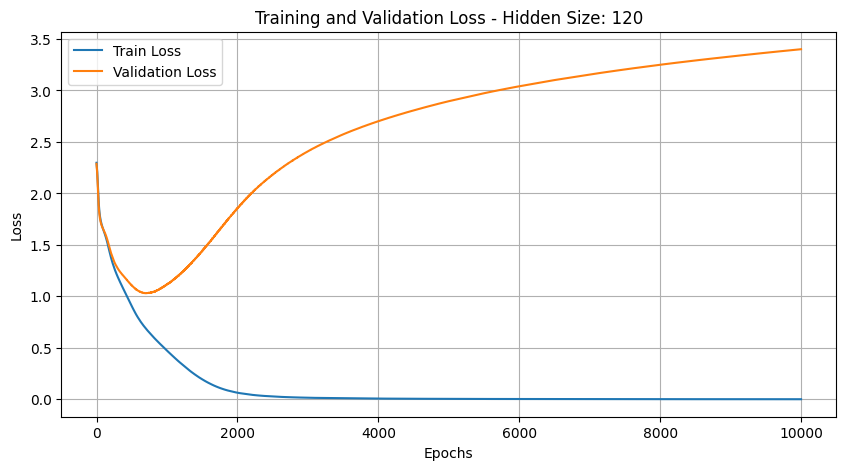


Entrenando modelo con 200 unidades ocultas
Epoch: 500/10000 | Train Loss: 0.78519 | Val Loss: 1.07325
Epoch: 1000/10000 | Train Loss: 0.30614 | Val Loss: 1.15327
Epoch: 1500/10000 | Train Loss: 0.07684 | Val Loss: 1.48792
Epoch: 2000/10000 | Train Loss: 0.02787 | Val Loss: 1.76355
Epoch: 2500/10000 | Train Loss: 0.01486 | Val Loss: 1.94372
Epoch: 3000/10000 | Train Loss: 0.00957 | Val Loss: 2.07052
Epoch: 3500/10000 | Train Loss: 0.00686 | Val Loss: 2.16935
Epoch: 4000/10000 | Train Loss: 0.00526 | Val Loss: 2.24945
Epoch: 4500/10000 | Train Loss: 0.00421 | Val Loss: 2.31570
Epoch: 5000/10000 | Train Loss: 0.00348 | Val Loss: 2.37212
Epoch: 5500/10000 | Train Loss: 0.00295 | Val Loss: 2.42148
Epoch: 6000/10000 | Train Loss: 0.00255 | Val Loss: 2.46525
Epoch: 6500/10000 | Train Loss: 0.00224 | Val Loss: 2.50462
Epoch: 7000/10000 | Train Loss: 0.00199 | Val Loss: 2.54042
Epoch: 7500/10000 | Train Loss: 0.00178 | Val Loss: 2.57326
Epoch: 8000/10000 | Train Loss: 0.00161 | Val Loss: 2.603

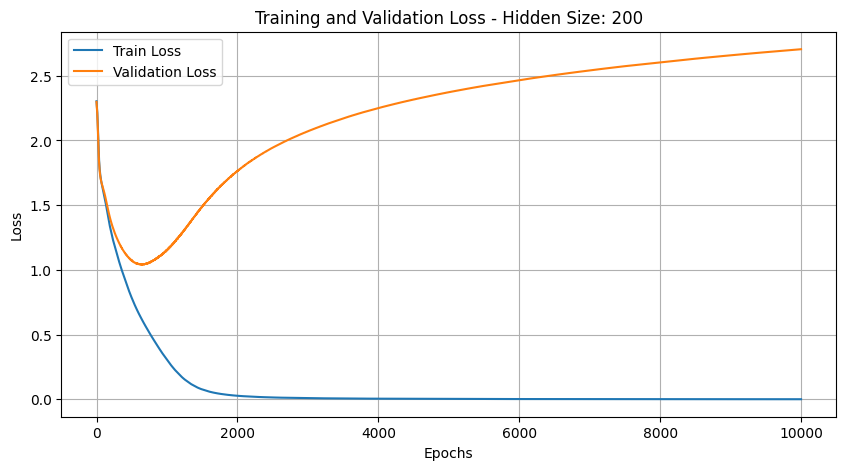


Entrenando modelo con 300 unidades ocultas
Epoch: 500/10000 | Train Loss: 0.68350 | Val Loss: 1.03655
Epoch: 1000/10000 | Train Loss: 0.20492 | Val Loss: 1.23169
Epoch: 1500/10000 | Train Loss: 0.04749 | Val Loss: 1.56446
Epoch: 2000/10000 | Train Loss: 0.01964 | Val Loss: 1.79263
Epoch: 2500/10000 | Train Loss: 0.01126 | Val Loss: 1.93919
Epoch: 3000/10000 | Train Loss: 0.00756 | Val Loss: 2.04657
Epoch: 3500/10000 | Train Loss: 0.00556 | Val Loss: 2.12991
Epoch: 4000/10000 | Train Loss: 0.00433 | Val Loss: 2.19781
Epoch: 4500/10000 | Train Loss: 0.00351 | Val Loss: 2.25478
Epoch: 5000/10000 | Train Loss: 0.00293 | Val Loss: 2.30356
Epoch: 5500/10000 | Train Loss: 0.00251 | Val Loss: 2.34620
Epoch: 6000/10000 | Train Loss: 0.00218 | Val Loss: 2.38459
Epoch: 6500/10000 | Train Loss: 0.00192 | Val Loss: 2.41936
Epoch: 7000/10000 | Train Loss: 0.00171 | Val Loss: 2.45077
Epoch: 7500/10000 | Train Loss: 0.00154 | Val Loss: 2.47980
Epoch: 8000/10000 | Train Loss: 0.00140 | Val Loss: 2.506

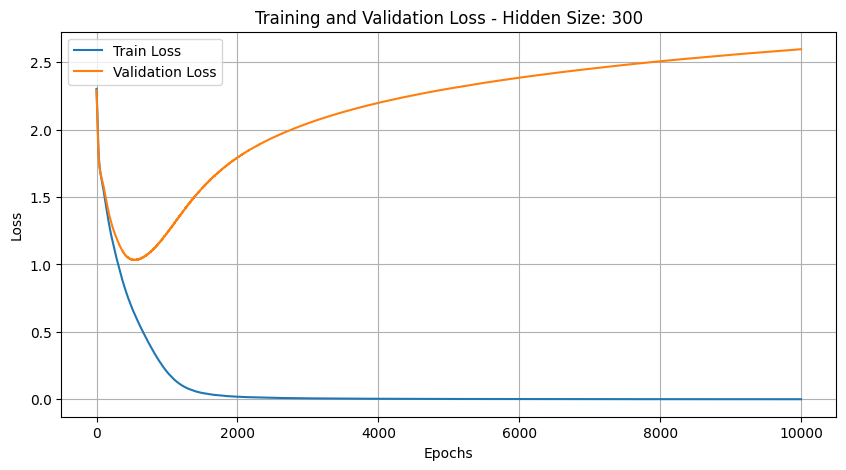

In [31]:
training_errors = []
validation_errors = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error = train_model(n_hidden, train_loader, val_loader)
    training_errors.append(train_error)
    validation_errors.append(val_error)


In [32]:
print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors:}")
print(f"Validación: {validation_errors}")


Entrenamiento finalizado. Errores finales:
Entrenamiento: [0.8510556930303573, 0.03422939981333911, 0.006194894638611004, 0.0052283372491365296, 0.005140147274069022, 0.003972626698669046, 0.003458721700590104, 0.003329051108448766, 0.003081502902205102, 0.002636188544711331, 0.002234862194018206, 0.0014279222121695056, 0.0011522054238594136, 0.0010121407177939546]
Validación: [1.8929118943214416, 7.270781574249267, 6.189029417037964, 5.624152405261993, 5.385247921943664, 5.430263247489929, 5.545007150173188, 5.172806706428528, 4.56514261841774, 4.220298727750778, 3.9484288156032563, 3.3999731826782225, 2.704266245365143, 2.595951461791992]


In [33]:
def plot_double_descent(training_errors, validation_errors, title="Curva Double Descent - MNIST-1D (sin ruido)", hidden_sizes=HIDDEN_SIZES):
    plt.figure(figsize=(15,5))
    plt.plot(hidden_sizes, training_errors, 'o-', label='Train Error')
    plt.plot(hidden_sizes, validation_errors, 'o-', label='Validation Error')

    plt.xticks(hidden_sizes)
    plt.xlabel('Número de unidades ocultas (capacidad del modelo)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

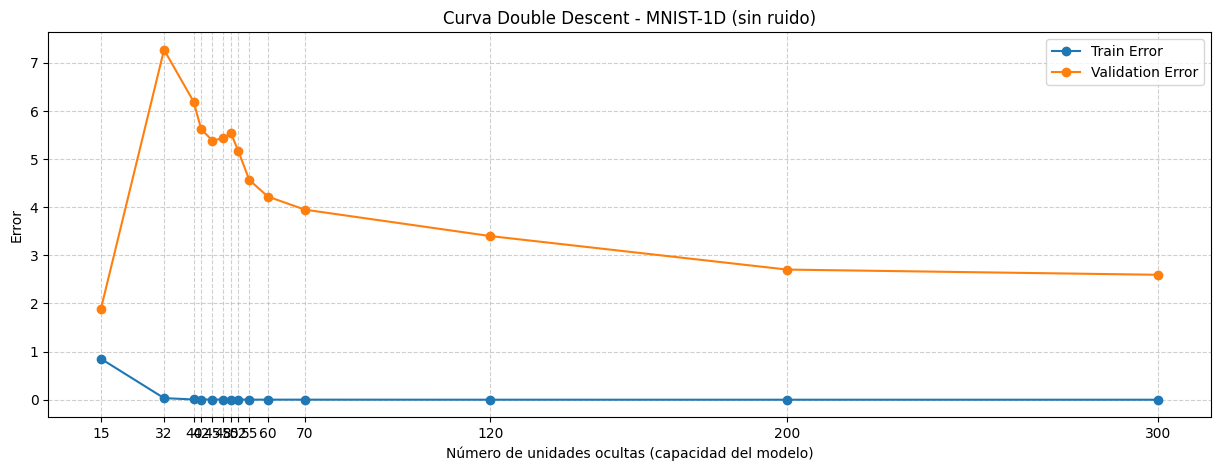

In [34]:
plot_double_descent(training_errors, validation_errors)


## Explorando el *Double Descent* con etiquetas ruidosas

En esta sección repetiremos el experimento anterior, pero introduciendo **ruido en las etiquetas** del conjunto de entrenamiento para analizar cómo afecta al fenómeno *Double Descent*.

Entrenaremos nuevamente el modelo con los mismos tamaños de capa oculta:  
`[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`,  
pero esta vez usaremos datasets en los que un porcentaje de las etiquetas ha sido aleatorizado. Realizaremos el experimento con dos niveles de ruido: **10 %** y **30 %**.

Después de entrenar los modelos para cada nivel de ruido, graficaremos las curvas de error de entrenamiento y prueba, similar a como lo hicimos anteriormente.

**Tu tarea:**

1. Ejecuta la celda siguiente para cargar los datasets con **10 %** y **30 %** de ruido.  
2. Adapta el código de entrenamiento y visualización de la sección anterior para entrenar los modelos con los conjuntos ruidosos y graficar los resultados.


In [35]:
# Carga el dataset MNIST-1D con 10% de ruido en las etiquetas de entrenamiento
data_noisy_10 = get_noisy_mnist1d_dataset(noise_rate=0.10)

# Puedes imprimir información sobre el dataset ruidoso para verificarlo
print("Dataset con 10% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_10['y']))
print("Ejemplos en prueba:", len(data_noisy_10['y_test']))
print("-" * 20)

# Repite el proceso para el 30% de ruido (modificando la tasa de ruido)
data_noisy_30 = get_noisy_mnist1d_dataset(noise_rate=0.30)

print("Dataset con 30% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_30['y']))
print("Ejemplos en prueba:", len(data_noisy_30['y_test']))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 10% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000
--------------------
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 30% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000


In [ ]:
train_loader_noisy_10, val_loader_noisy_10 = get_dataloaders(data_noisy_10)
training_errors_noisy_10 = []
validation_errors_noisy_10 = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error = train_model(n_hidden, train_loader_noisy_10, val_loader_noisy_10)
    training_errors_noisy_10.append(train_error)
    validation_errors_noisy_10.append(val_error)

print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors_noisy_10}")
print(f"Validación: {validation_errors_noisy_10}")



Entrenando modelo con 15 unidades ocultas
Epoch: 500/10000 | Train Loss: 1.56163 | Val Loss: 1.64360


In [ ]:
plot_double_descent(training_errors_noisy_10, validation_errors_noisy_10, title="Curva Double Descent - MNIST-1D (10% de ruido)")


In [ ]:
train_loader_noisy_30, val_loader_noisy_30 = get_dataloaders(data_noisy_30)
training_errors_noisy_30 = []
validation_errors_noisy_30 = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error = train_model(n_hidden, train_loader_noisy_30, val_loader_noisy_30)
    training_errors_noisy_30.append(train_error)
    validation_errors_noisy_30.append(val_error)

print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors_noisy_30}")
print(f"Validación: {validation_errors_noisy_30}")

In [ ]:
plot_double_descent(training_errors_noisy_30, validation_errors_noisy_30, title="Curva Double Descent - MNIST-1D (30% de ruido)")


## Preguntas finales

1. ¿Cómo afecta el **ruido en las etiquetas** al error mínimo de entrenamiento alcanzable? ¿Por qué ocurre esto?  
2. Según tus observaciones, ¿cómo influye el **ruido en las etiquetas** en el fenómeno de *Double Descent*, especialmente en relación con la **capacidad del modelo** y su **capacidad de generalización**?  
3. En *Deep Learning*, ¿es lo mismo el **overfitting** durante el entrenamiento que la **sobreparametrización** de los modelos? Explica las diferencias.


### 1. ¿Cómo afecta el ruido en las etiquetas al error mínimo de entrenamiento alcanzable?

En las tres curvas se ve que el error de entrenamiento siempre termina llegando prácticamente a cero, incluso cuando hay ruido en las etiquetas.
Esto pasa porque los modelos con mucha capacidad son capaces de memorizar los datos del conjunto de entrenamiento, aunque parte de esas etiquetas sean incorrectas.
### 2.¿Cómo influye el ruido en las etiquetas en el fenómeno de Double Descent?

El fenómeno de Double Descent aparece cuando el error de validación primero baja, después sube (alrededor del punto donde el modelo empieza a memorizar los datos) y finalmente vuelve a bajar cuando la red es tan grande que logra generalizar otra vez.
En el caso sin ruido, se nota claramente esa forma: el error de validación disminuye al principio, luego sube entre 45 y 70 unidades ocultas, y finalmente baja de nuevo cuando el modelo tiene muchas más neuronas.
En cambio, cuando hay ruido, ese pico se vuelve más alto y ancho, y la segunda bajada casi desaparece.
Esto pasa porque al haber etiquetas erróneas el modelo no puede volver a generalizar bien, ya que termina memorizando información contradictoria. Cuanto más ruido, más difícil es ver el “segundo descenso” típico del Double Descent.

### 3. En Deep Learning, ¿es lo mismo el overfitting que la sobreparametrización?

No, no son lo mismo. El overfitting pasa cuando el modelo se ajusta tanto a los datos de entrenamiento que empieza a aprender también el ruido y los detalles específicos del dataset, perdiendo capacidad de generalizar.
La sobreparametrización, en cambio, se refiere a cuando el modelo tiene más parámetros que ejemplos de entrenamiento, o sea, mucha más capacidad de la necesaria para aprender la tarea.
Tradicionalmente se pensaba que más parámetros siempre llevaban a más overfitting, pero con las redes profundas pasa algo distinto: los modelos muy grandes pueden volver a generalizar bien gracias al segundo descenso del Double Descent.
En resumen, el overfitting ocurre durante el entrenamiento, mientras que la sobreparametrización describe el tamaño del modelo, y aunque pueden estar relacionados, no significan lo mismo.